In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import os
import plotly.express as px

In [2]:
customers = pd.read_csv('C:/Users/makog/KC lessons/jupyter-s-makogon _from_KC/my_lessons/For_GIT_Folder/olist_customers_dataset.csv')
orders = pd.read_csv('C:/Users/makog/KC lessons/jupyter-s-makogon _from_KC/my_lessons/For_GIT_Folder/olist_orders_dataset.csv' \
                    , parse_dates=[3, 4, 5, 6, 7], dayfirst=True)
items = pd.read_csv('C:/Users/makog/KC lessons/jupyter-s-makogon _from_KC/my_lessons/For_GIT_Folder/olist_order_items_dataset.csv' \
                   , parse_dates=['shipping_limit_date'], dayfirst=True)

Каждый датасет проверен на дубликаты (нет), наны/наты (ожидаемы и логичны). С типами данных все ОК, даты распарсил при считывании.

Покупкой определим оплаченные и доставленные, но не отмененные заказы. Фактом оплаты и доставки считаем наличие данных в соответствующих колонках (не NaT). Статус в данном случае вторичен, т.к. имеется несогласованность данных: 8 заказов со статусом "delivered" не имеют заполненную дату доставки.
Доставленные, но не оплаченные заказы (14 ед., возможно подарки) не попадают под наши критерии покупки.  
Также необходимо учесть, что 6 оплаченных и доставленных заказов были отменены.
Доля заказов, подходящих под наши критерии покупки 97%. 

In [3]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [4]:
orders.query('order_status == "delivered" and order_delivered_customer_date == "NaT"').shape

(8, 8)

In [5]:
orders.query('order_delivered_customer_date != "NaT" and order_approved_at == "NaT"').shape

(14, 8)

In [6]:
orders.query('order_delivered_customer_date != "NaT" and order_approved_at != "NaT" and order_status == "canceled"').shape

(6, 8)

In [7]:
purchases = orders.query('order_delivered_customer_date != "NaT" and order_approved_at != "NaT" and order_status != "canceled"')

In [8]:
round(purchases.shape[0] / orders.shape[0] * 100, 2)

97.0

1. Сколько у нас пользователей, которые совершили покупку только один раз?

Ответ: Таких пользователей 90537 (94%)

In [9]:
purchases.sort_values('order_purchase_timestamp').tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
99369,52018484704db3661b98ce838612b507,e450a297a7bc6839ceb0cf1a2377fa02,delivered,2018-08-29 12:25:59,2018-08-29 12:35:17,2018-08-29 13:38:00,2018-08-30 22:48:27,2018-09-03
30077,0b223d92c27432930dfe407c6aea3041,e60df9449653a95af4549bbfcb18a6eb,delivered,2018-08-29 14:18:23,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04
31486,168626408cb32af0ffaf76711caae1dc,6e353700bc7bcdf6ebc15d6de16d7002,delivered,2018-08-29 14:18:28,2018-08-29 14:30:23,2018-08-29 18:51:00,2018-08-30 16:52:31,2018-09-11
69678,03ef5dedbe7492bdae72eec50764c43f,496630b6740bcca28fce9ba50d8a26ef,delivered,2018-08-29 14:52:00,2018-08-29 15:05:22,2018-08-29 20:01:00,2018-08-30 16:36:59,2018-09-03
88097,35a972d7f8436f405b56e36add1a7140,898b7fee99c4e42170ab69ba59be0a8b,delivered,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-08-29 16:57:00,2018-08-30 16:23:36,2018-09-05


In [10]:
purchases.nunique()

order_id                         96456
customer_id                      96456
order_status                         1
order_purchase_timestamp         95934
order_approved_at                88267
order_delivered_carrier_date     80094
order_delivered_customer_date    95644
order_estimated_delivery_date      445
dtype: int64

In [11]:
cust_pursh = purchases.customer_id

In [12]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [13]:
customers_one_pursh = customers.query('customer_id in @cust_pursh') \
                                .groupby('customer_unique_id', as_index=False) \
                                .agg({'customer_id': 'count'}) \
                                .query('customer_id == 1') \
                                .shape[0]
customers_one_pursh

90537

In [14]:
round(customers_one_pursh / customers.customer_unique_id.nunique() *100, 0)

94.0

In [15]:
# Проверка через мердж
purchases.merge(customers, how='left', on='customer_id') \
        .groupby('customer_unique_id', as_index=False) \
        .agg({'order_id': 'count'}) \
        .query('order_id == 1') \
        .shape[0]
        

90537

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Заказ считается недоставленным, если время доставки == НаТ и статус != delivered.

Сформулируем причины:

1.Заказ не доставлен, т.к. отменен (статус - canceled)

2.Заказ не досатвлен, т.к. недоступен (статус - unavailable)

3.Заказ не досатвлен из-за проблем логистики (статус - shipped)

4.Заказ не досатвлен по причине незавершения операций оформления (операции со статусами created, approved, invoiced, processing)

Считаем по колонке время создания заказа

In [16]:
un_delivered = orders.query('order_delivered_customer_date == "NaT" and order_status != "delivered"') \
        .sort_values('order_purchase_timestamp')

In [17]:
un_delivered

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
4541,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaT,NaT,2016-10-25
76582,1aecadf4362edaca7fa033e882076c8d,e81a9f176936e3124dfd90c483bf3289,canceled,2016-10-04 10:05:45,2016-10-04 10:26:40,NaT,NaT,2016-11-24
...,...,...,...,...,...,...,...,...
50387,392ed9afd714e3c74767d0c4d3e3f477,2823ffda607a2316375088e0d00005ec,canceled,2018-09-29 09:13:03,NaT,NaT,NaT,2018-10-15
88500,616fa7d4871b87832197b2a137a115d2,bf6181a85bbb4115736c0a8db1a53be3,canceled,2018-10-01 15:30:09,NaT,NaT,NaT,2018-10-23
31891,a2ac6dad85cf8af5b0afb510a240fe8c,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10-03 18:55:29,NaT,NaT,NaT,2018-10-16
68373,b059ee4de278302d550a3035c4cdb740,856336203359aa6a61bf3826f7d84c49,canceled,2018-10-16 20:16:02,NaT,NaT,NaT,2018-11-12


In [18]:
un_delivered.order_purchase_timestamp = un_delivered.order_purchase_timestamp.dt.to_period('M')

In [19]:
un_delivered

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
4541,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20
4396,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09,2016-10-07 13:17:15,NaT,NaT,2016-10-28
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09,2016-10-07 13:16:46,NaT,NaT,2016-09-30
83078,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10,2016-10-06 15:50:56,NaT,NaT,2016-10-25
76582,1aecadf4362edaca7fa033e882076c8d,e81a9f176936e3124dfd90c483bf3289,canceled,2016-10,2016-10-04 10:26:40,NaT,NaT,2016-11-24
...,...,...,...,...,...,...,...,...
50387,392ed9afd714e3c74767d0c4d3e3f477,2823ffda607a2316375088e0d00005ec,canceled,2018-09,NaT,NaT,NaT,2018-10-15
88500,616fa7d4871b87832197b2a137a115d2,bf6181a85bbb4115736c0a8db1a53be3,canceled,2018-10,NaT,NaT,NaT,2018-10-23
31891,a2ac6dad85cf8af5b0afb510a240fe8c,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10,NaT,NaT,NaT,2018-10-16
68373,b059ee4de278302d550a3035c4cdb740,856336203359aa6a61bf3826f7d84c49,canceled,2018-10,NaT,NaT,NaT,2018-11-12


In [20]:
un_delivered_by_reasons = un_delivered.groupby(['order_purchase_timestamp', 'order_status'], as_index=False) \
                                                    .agg({'order_id': 'count'}) \
                                                    .rename(columns={'order_id': 'undelivered_num'})

In [21]:
un_delivered_by_reasons.head(10)

,order_purchase_timestamp,order_status,undelivered_num
0,2016-09,canceled,2
1,2016-09,shipped,1
2,2016-10,canceled,19
3,2016-10,invoiced,18
4,2016-10,processing,2
5,2016-10,shipped,8
6,2016-10,unavailable,7
7,2017-01,canceled,3
8,2017-01,invoiced,12
9,2017-01,processing,9


In [22]:
# сгруппируем причины, связанные с незавершением операции оформления в одну not_complete

un_delivered_by_reasons['order_status'] = un_delivered_by_reasons['order_status']\
    .apply(lambda x: 'not_complete' if x in ['created', 'approved', 'invoiced', 'processing'] else x)

<AxesSubplot:xlabel='order_purchase_timestamp', ylabel='undelivered_num'>

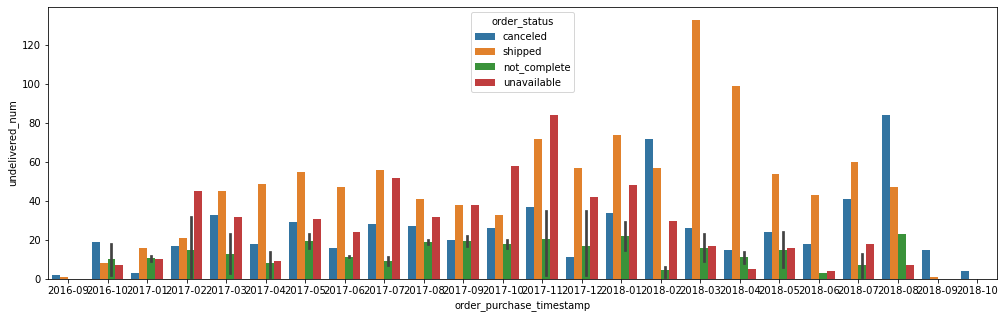

In [23]:
plt.figure(figsize=(17, 5))
sns.barplot(x='order_purchase_timestamp', y='undelivered_num', hue='order_status', data=un_delivered_by_reasons)

In [24]:
# Визуализация достаточна информативна, но от нас требуется среднее количество недоставленных заказов в месяц
un_delivered.groupby('order_purchase_timestamp', as_index=False) \
            .agg({'order_id': 'count'}) \
            .mean()

C:\Users\makog\AppData\Local\Temp\ipykernel_18804\2975812564.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  un_delivered.groupby('order_purchase_timestamp', as_index=False) \


order_id    123.208333
dtype: float64

In [25]:
un_delivered_by_reasons

,order_purchase_timestamp,order_status,undelivered_num
0,2016-09,canceled,2
1,2016-09,shipped,1
2,2016-10,canceled,19
3,2016-10,not_complete,18
4,2016-10,not_complete,2
...,...,...,...
108,2018-08,shipped,47
109,2018-08,unavailable,7
110,2018-09,canceled,15
111,2018-09,shipped,1


In [26]:
un_delivered_by_reasons = un_delivered_by_reasons.groupby('order_status', as_index=False)\
                                                .agg({'undelivered_num': 'sum'})

In [27]:
un_delivered_by_reasons['reason_weight'] = round(un_delivered_by_reasons['undelivered_num']\
                                                 / un_delivered_by_reasons['undelivered_num'].sum()\
                                                 * 100, 0)

In [28]:
un_delivered_by_reasons

,order_status,undelivered_num,reason_weight
0,canceled,619,21.0
1,not_complete,622,21.0
2,shipped,1107,37.0
3,unavailable,609,21.0


Менеджеру Василию можно ответить так: в среднем в месяц не доставляется 123 заказа по причинам:

проблемы логистики - 37% случаев

незавершение операций оформления, отмены и недоступности заказов (что бы это ни значило) - по 21% случаев.

Показать помесячную визуализацию и получить новую задачу проанализировать аномалии :)

3. По каждому товару определить, в какой день недели товар чаще всего покупается

На мой взгляд, здесь целесообразно переформулировать вопрос (или определение покупки) и посмотреть по дате создания заказа, а не по дате подтвреждения оплаты, т.к. создание заказа это первый контакт с клиентом и знание зависимости по дням недели будет для бизнеса полезней, чем оплата, на которую влияют разные факторы (наличие денег у заказчика, время обработки платежа и т.д.)

In [29]:
purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [30]:
items.tail()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72
112649,fffe41c64501cc87c801fd61db3f6244,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.00,12.79


In [31]:
items_purchased = items.merge(purchases[['order_id', 'order_purchase_timestamp']], how='inner', on='order_id')

In [32]:
items_purchased.order_purchase_timestamp = items_purchased.order_purchase_timestamp.dt.day_name()

In [33]:
items_purchased

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,Saturday
...,...,...,...,...,...,...,...,...
110169,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,Monday
110170,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,Saturday
110171,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,Monday
110172,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,Monday


In [34]:
items_by_day = items_purchased.groupby(['product_id', 'order_purchase_timestamp'], as_index=False) \
                            .agg({'order_id': 'count'}) \
                            .sort_values('product_id')

In [35]:
items_by_day

,product_id,order_purchase_timestamp,order_id
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
59937,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
59938,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
59935,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
59936,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1


In [36]:
items_by_day_wide = items_by_day.pivot(index='product_id', columns='order_purchase_timestamp', values='order_id')

In [37]:
items_by_day_wide.head()

order_purchase_timestamp,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,NaN,NaN,NaN,1.0,NaN,NaN,NaN
00088930e925c41fd95ebfe695fd2655,NaN,NaN,NaN,NaN,NaN,1.0,NaN
0009406fd7479715e4bef61dd91f2462,NaN,NaN,NaN,NaN,1.0,NaN,NaN
000b8f95fcb9e0096488278317764d19,1.0,NaN,NaN,NaN,NaN,NaN,1.0
000d9be29b5207b54e86aa1b1ac54872,NaN,NaN,NaN,NaN,NaN,1.0,NaN


Исходя из буквальной трактовки задания (по каждому товару определить, в какой день недели товар чаще всего покупается), день недели должен быть указан один, хотя некоторые товары покупются одинаково в разные дни. Поэтому, если максимальное количество купленного товара встречается в разные дни, мы не можем выделить ОДИН такой день.

In [38]:
days_max = {}
# итерируемся по дф
for index, row in items_by_day_wide.iterrows():
    num = 0
    counter = 0
# итерируемся по серии в поисках макс.значения, результат в виде дня недели записываем в словарь  
    for i in range(7):
        if row[i] >= num:
            num = row[i]
            days_max[index] = row.index[i]
# снова проходим по серии с целью посчитать количество макс.значений    
    for j in range(7):
        if row[j] == num:
            counter += 1
# исключаем из словаря дубли с макс.значениями, присваивая им Наны
    if counter > 1:
        days_max[index] = 'NaN'

In [39]:
items_by_day_wide = items_by_day_wide.assign(best_day = days_max.values())

In [40]:
items_by_day_wide

order_purchase_timestamp,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,best_day
product_id,,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Sunday
00088930e925c41fd95ebfe695fd2655,NaN,NaN,NaN,NaN,NaN,1.0,NaN,Tuesday
0009406fd7479715e4bef61dd91f2462,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Thursday
000b8f95fcb9e0096488278317764d19,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
000d9be29b5207b54e86aa1b1ac54872,NaN,NaN,NaN,NaN,NaN,1.0,NaN,Tuesday
...,...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
fff81cc3158d2725c0655ab9ba0f712c,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Monday
fff9553ac224cec9d15d49f5a263411f,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Friday


<AxesSubplot:>

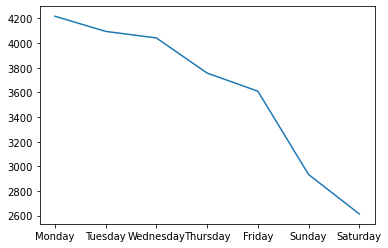

In [41]:
items_by_day_wide.query('best_day != "NaN"').best_day.value_counts(normalize=False).plot()

    4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [42]:
# Моя интерпретация метрики "Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)":
# КОЛИЧЕСТВО ПОКУПОК В МЕСЯЦ / КОЛИЧЕСТВО НЕДЕЛЬ В ЭТОМ МЕСЯЦЕ

In [43]:
purchases.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03


In [44]:
purch_by_cust_uniq = purchases.merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')

In [45]:
purch_by_cust_uniq.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6


In [46]:
# поскольку, как мы выяснили ранее, 94% пользователей совершили только одну покупку, нет смысла по ним считать среднее
# посмотрим ближе на тех, у кого более одной покупки

In [47]:
more_one_purcheses = purch_by_cust_uniq.groupby('customer_unique_id', as_index=False) \
                                .agg({'order_id': 'count'}) \
                                .sort_values('order_id', ascending=False) \
                                .query('order_id > 1')

In [48]:
more_one_purcheses

,customer_unique_id,order_id
51421,8d50f5eadf50201ccdcedfb9e2ac8455,15
22774,3e43e6105506432c953e165fb2acf44c,9
10058,1b6c7548a2a1f9037c1fd3ddfed95f33,7
36700,6469f99c1f9dfae7733b25662e7f1782,7
73906,ca77025e7201e3b30c44b472ff346268,7
...,...,...
23363,3fe3e628c6c7a15ae96416826a4c5952,2
46368,7ee9e6c80bf1b7ec4a52639eab6c128c,2
68015,ba54ee5be417c0558c060a3186451248,2
23554,407a6773db6e845737d04a6e27e653b4,2


In [49]:
# отберем из тех, кто совершил более одной покупки, тех, чьи покупки пришлись на один месяц
# одна покупка в месяц нам неинтересна, т.к. наша метрика не будет отличаться от тех, у кого всего одна покупка
# (от 0,226 до 0,25 в зависмотсти от месяца)


In [50]:
more_one_purcheses_month = purch_by_cust_uniq.query('customer_unique_id in @more_one_purcheses.customer_unique_id') \
                                        .set_index('order_approved_at') \
                                        .groupby('customer_unique_id') \
                                        .order_id \
                                        .resample(rule='1M') \
                                        .count()\
                                        .to_frame() \
                                        .query('order_id > 1')

In [51]:
more_one_purcheses_month.sort_values('order_id', ascending=False)

,,order_id
customer_unique_id,order_approved_at,
12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-31,6
b08fab27d47a1eb6deda07bfd965ad43,2017-09-30,4
3e43e6105506432c953e165fb2acf44c,2018-02-28,4
83e7958a94bd7f74a9414d8782f87628,2017-01-31,4
25a560b9a6006157838aab1bdbd68624,2017-04-30,4
...,...,...
5b26618da34612cc4947bbf6ef4fb67c,2018-02-28,2
5b09c620db60411b0be6f1817c6cbe71,2017-08-31,2
5af895ee7ff98368a5bf6faeddd18cec,2018-02-28,2


In [52]:
more_one_purcheses_month.value_counts()

order_id
2           1176
3             43
4              7
6              1
dtype: int64

In [53]:
more_one_purcheses_month = more_one_purcheses_month.sort_values('order_id', ascending=False) \
                    .reset_index()

In [54]:
more_one_purcheses_month = more_one_purcheses_month.assign( \
                                    days_in_month = more_one_purcheses_month.order_approved_at.dt.daysinmonth / 7)
more_one_purcheses_month = more_one_purcheses_month.assign( \
                                    mean_in_week_by_month = more_one_purcheses_month.order_id / more_one_purcheses_month.days_in_month)

In [55]:
# Это и будет ответом
more_one_purcheses_month.head(10)

,customer_unique_id,order_approved_at,order_id,days_in_month,mean_in_week_by_month
0,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-31,6,4.428571,1.354839
1,b08fab27d47a1eb6deda07bfd965ad43,2017-09-30,4,4.285714,0.933333
2,3e43e6105506432c953e165fb2acf44c,2018-02-28,4,4.000000,1.000000
3,83e7958a94bd7f74a9414d8782f87628,2017-01-31,4,4.428571,0.903226
4,25a560b9a6006157838aab1bdbd68624,2017-04-30,4,4.285714,0.933333
5,c8460e4251689ba205045f3ea17884a1,2018-08-31,4,4.428571,0.903226
6,a239b8e2fbce33780f1f1912e2ee5275,2017-02-28,4,4.000000,1.000000
7,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-28,4,4.000000,1.000000
8,ec7f1811826ab04a27a92197bc40c888,2017-11-30,3,4.285714,0.700000
9,e13e8b789e5a8e6fe1445f924a4ed4f6,2018-06-30,3,4.285714,0.700000


5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Признак формирования когорты — первый заказ сделан в 2017 году.

Размер когорты — временной интервал - месяц.

Отчетный период — один год (2017).

Анализируемый ключевой показатель -  Retention, т.е. коэффициент повторных заказов

In [56]:
cust_uniq_order = orders[['customer_id', 'order_purchase_timestamp']].merge( \
                customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')

In [57]:
cust_uniq_order = cust_uniq_order.sort_values('order_purchase_timestamp') \
                                .query('order_purchase_timestamp >= "2017-01-01" and order_purchase_timestamp < "2018-01-01"')

In [58]:
cust_uniq_order['month'] = cust_uniq_order['order_purchase_timestamp'].dt.to_period('M')

In [59]:
# Заметка о transform()

# В то время как агрегирующая функция должна возвращать сокращенную версию данных, transform может вернуть версию 
#полного набора данных, преобразованную ради дальнейшей их перекомпоновки. При подобном преобразовании форма выходных 
#данных совпадает с формой входных.

In [60]:
cust_uniq_order['cohort'] = cust_uniq_order.groupby('customer_unique_id')['order_purchase_timestamp'] \
                                             .transform('min') \
                                             .dt.to_period('M')

In [61]:
cust_uniq_order.head()

,customer_id,order_purchase_timestamp,customer_unique_id,month,cohort
78768,c24fc5f9a446b4d8262041b9c64de772,2017-01-05 11:56:06,f7b981e8a280e455ac3cbe0d5d171bd1,2017-01,2017-01
16201,ff3c6d35b4927c9b965aa6a68dcf56e4,2017-01-05 12:01:20,83e7958a94bd7f74a9414d8782f87628,2017-01,2017-01
74670,d2c63ad286e3ca9dd69218008d61ff81,2017-01-05 12:06:36,728e4a7d0db4845270091ded0923c71f,2017-01,2017-01
15352,e6bee29442c761ff0dfb9a4414922a5c,2017-01-05 12:09:08,728e4a7d0db4845270091ded0923c71f,2017-01,2017-01
27002,42d857e22f61f10476f0cda1aacc018a,2017-01-05 12:11:23,728e4a7d0db4845270091ded0923c71f,2017-01,2017-01


In [62]:
cohort_df = cust_uniq_order.groupby(['cohort', 'month'], as_index=False) \
                            .agg({'customer_unique_id': 'nunique'}) \
                            .rename(columns={'customer_unique_id': 'customer_count'})

In [63]:
#полезная функция из operator attrgetter(name) – для получение значения атрибута объекта с именем name

from operator import attrgetter

cohort_df['period_num'] = (cohort_df.month - cohort_df.cohort) \
            .apply(attrgetter('n'))

In [64]:
cohort_df.head(20)

,cohort,month,customer_count,period_num
0,2017-01,2017-01,765,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
5,2017-01,2017-06,1,5
6,2017-01,2017-07,4,6
7,2017-01,2017-08,1,7
8,2017-01,2017-09,1,8
9,2017-01,2017-11,3,10


In [65]:
cohort_pivot = cohort_df.pivot_table(index='cohort', columns='period_num', values='customer_count')

In [66]:
# в данном случае в когортах абс.количество заказчиков. чтобы получить ретеншен, нужно поделить их число за каждый месяц на кол-во в 1м

cohort_pivot

period_num,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,765.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,NaN,NaN
2017-04,2353.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN
2017-07,3895.0,20.0,14.0,10.0,11.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4184.0,29.0,14.0,11.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4131.0,28.0,22.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
cohort_size = cohort_pivot[0]
retention_df = cohort_pivot.divide(cohort_size, axis=0).mul(100)

In [68]:
retention_df

period_num,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,100.0,0.392157,0.261438,0.130719,0.392157,0.130719,0.522876,0.130719,0.130719,NaN,0.392157,0.130719
2017-02,100.0,0.228311,0.285388,0.114155,0.399543,0.114155,0.228311,0.171233,0.171233,0.228311,0.114155,NaN
2017-03,100.0,0.493171,0.379363,0.379363,0.341426,0.151745,0.151745,0.303490,0.341426,0.075873,NaN,NaN
2017-04,100.0,0.594985,0.212495,0.169996,0.339992,0.254994,0.339992,0.297493,0.297493,NaN,NaN,NaN
2017-05,100.0,0.500556,0.500556,0.389321,0.305895,0.333704,0.417130,0.166852,NaN,NaN,NaN,NaN
2017-06,100.0,0.477859,0.350430,0.414145,0.254858,0.382287,0.382287,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,0.513479,0.359435,0.256739,0.282413,0.205392,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.693117,0.334608,0.262906,0.358509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.677802,0.532559,0.290487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='period_num', ylabel='cohort'>

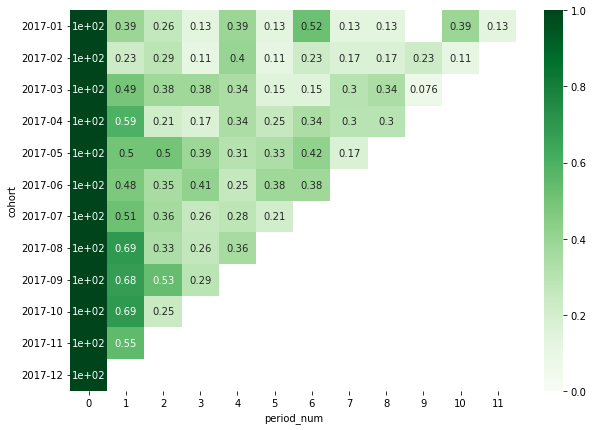

In [69]:
fig, ax = plt.subplots(figsize=(10,7)) 
sns.heatmap(retention_df, vmin=0, vmax=1, cmap="Greens", annot=True, ax=ax)

<AxesSubplot:xlabel='cohort'>

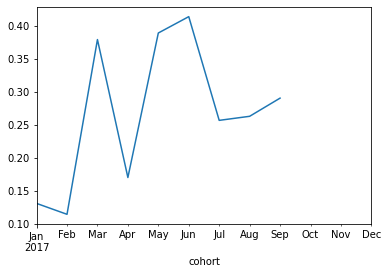

In [70]:
# Самый высокий ретеншен на 3й месяц в кагорте пользователей, 
# которые совершили первый в 2017 году заказ в июне.

retention_df[3].plot()

6.Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

Recency: Когда пользователь последний раз совершил покупку. Recency = number of days since last purchase

Frequency: Как часто пользователь совершает покупки. Freqency = number of purchases during the studied period (usually one year)

Monetary: Сколько денег пользователь потратил всего. Monetary = total amount of purchases made during the studied period

Период возьмем последние 12 месяцев, т.е. с 2017-08-29, т.к. поведение пользователей со временем меняется и старые данные могут негативно повлиять на сегментацию. Кроме того, ниже установлено, что количество людей, сделавших вторую покупку по истечении года ничтожно мало (0.04%).

Используем датасет purchases, т.к. пользователей будем сегментировать по покупкам (факт оплаты важен)

In [71]:
#воспользуемся предыдущим датасетом
#purch_by_cust_uniq = purchases.merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')

In [72]:
purch_by_cust_uniq_one_year = purch_by_cust_uniq.query('order_purchase_timestamp > "2017-08-30"')

In [73]:
purch_by_cust_uniq_one_year.nunique()

order_id                         74522
customer_id                      74522
order_status                         1
order_purchase_timestamp         74104
order_approved_at                66878
order_delivered_carrier_date     60048
order_delivered_customer_date    74006
order_estimated_delivery_date      269
customer_unique_id               72543
dtype: int64

In [74]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [75]:
#подготовим items к джойну, считаем сумму по прайсу, т.к. каждый товар в единичном измерении

items_by_order_id = items.groupby('order_id', as_index=False).agg({'price': 'sum'}).rename(columns={'price': 'purch_sum'})

In [76]:
uniq_cust_with_orders = purch_by_cust_uniq_one_year[['customer_unique_id', 'order_id', 'order_approved_at']] \
            .merge(items_by_order_id, how='right', on='order_id')

In [77]:
#проверка - уник.пользователей и число заказов не потеряли

uniq_cust_with_orders.nunique()

customer_unique_id    72543
order_id              98666
order_approved_at     66878
purch_sum              7761
dtype: int64

In [78]:
#Наны можно дропнуть

uniq_cust_with_orders.dropna(inplace=True)

In [79]:
#посчитаем частоту покупок по пользователям

frequency = uniq_cust_with_orders.groupby('customer_unique_id', as_index=True) \
                            .agg({'order_id': 'count'}) \
                            .rename(columns={'order_id': 'frequency'}) \
                            .sort_values('frequency', ascending=False)

In [80]:
frequency.head()

,frequency
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,11
3e43e6105506432c953e165fb2acf44c,9
ca77025e7201e3b30c44b472ff346268,7
6469f99c1f9dfae7733b25662e7f1782,7
1b6c7548a2a1f9037c1fd3ddfed95f33,7


In [81]:
# посчитаем давность (Recency) покупки

In [82]:
NOW = uniq_cust_with_orders['order_approved_at'].max() + datetime.timedelta(days=1)
NOW

Timestamp('2018-08-30 15:10:26')

In [83]:
uniq_cust_with_orders['days_since_purch'] = uniq_cust_with_orders['order_approved_at'].apply(lambda x: (NOW - x).days)

In [84]:
recency = uniq_cust_with_orders.groupby('customer_unique_id', as_index=True) \
                        .agg({'days_since_purch': 'min'}) \
                        .rename(columns={'days_since_purch': 'recency'}) \
                        .sort_values('recency')

In [85]:
recency.tail()

,recency
customer_unique_id,
140a739017666e061d00177428afcd55,365
89bfe07c825cb356d8adb48036689efc,365
caa82063c22259dc33023f5368f77220,365
8215ca540d5abcc9e3564f69e898769f,365
cadf5efd7e29678690c09cc039e08bc6,365


In [86]:
#Посчитаем сумму заработанных с пользователя денег за период (Monetary)

monetary = uniq_cust_with_orders.groupby('customer_unique_id', as_index=True) \
                                .agg({'purch_sum': 'sum'}) \
                                .rename(columns={'purch_sum': 'monetary'})

In [87]:
monetary.head()

,monetary
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
0000f6ccb0745a6a4b88665a16c9f078,25.99
0004aac84e0df4da2b147fca70cf8255,180.00
0004bd2a26a76fe21f786e4fbd80607f,154.00


In [88]:
rfm = pd.concat([recency, frequency, monetary], axis=1).reset_index().rename(columns={'index': 'customer_unique_id'})

In [89]:
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,55cfdb1ec3c5bf60d9ccc0d5f276f8a9,1,1,250.00
1,1041688b50cfd8ef6df6086a1746a30c,1,2,41.80
2,ca36d819c1759cdb6257fef0bb5d362d,1,1,7.50
3,afbcfd0b9c5233e7ccc73428526fbb52,1,1,457.75
4,0c6d7218d5f3fa14514fd29865269993,1,1,169.80


In [90]:
# для установления границ сегментов поизучаем данные

In [91]:
rfm.describe()

,recency,frequency,monetary
count,72543.000000,72543.00000,72543.000000
mean,172.965565,1.02728,141.095977
std,99.948043,0.18605,211.871185
min,1.000000,1.00000,0.850000
25%,88.000000,1.00000,47.900000
50%,172.000000,1.00000,89.800000
75%,260.000000,1.00000,152.000000
max,365.000000,11.00000,13440.000000


In [92]:
# Найдем среднее количество дней между 1й и 2й покупкой, чтобы более точно определить recency (лучший сегмент)

In [93]:
purch_by_cust_uniq.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6


In [94]:
#пользователи, которые совершили более одной покупки

customer_over_one_purch = purch_by_cust_uniq.groupby('customer_unique_id', as_index=False) \
                                            .agg({'customer_id': 'count'}) \
                                            .query('customer_id > 1') \
                                            .customer_unique_id

In [95]:
purch_by_cust_uniq_over_one = purch_by_cust_uniq.query('customer_unique_id in @customer_over_one_purch')

In [96]:
purch_by_cust_uniq_over_one['min_date'] = purch_by_cust_uniq_over_one.groupby('customer_unique_id')['order_approved_at'] \
                                            .transform('min') \
                                            .dt.to_period('D')

C:\Users\makog\AppData\Local\Temp\ipykernel_18804\3674059913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purch_by_cust_uniq_over_one['min_date'] = purch_by_cust_uniq_over_one.groupby('customer_unique_id')['order_approved_at'] \


In [97]:
purch_by_cust_uniq_over_one.drop(columns=['order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date', \
                                           'order_delivered_customer_date', 'order_estimated_delivery_date'], inplace=True)

C:\Users\makog\AppData\Local\Temp\ipykernel_18804\1818705954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purch_by_cust_uniq_over_one.drop(columns=['order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date', \


In [98]:
purch_by_cust_uniq_over_one['since_days'] = (purch_by_cust_uniq_over_one['order_approved_at'].dt.to_period('D') - \
                                            purch_by_cust_uniq_over_one['min_date']).apply(attrgetter('n'))

C:\Users\makog\AppData\Local\Temp\ipykernel_18804\1564836364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purch_by_cust_uniq_over_one['since_days'] = (purch_by_cust_uniq_over_one['order_approved_at'].dt.to_period('D') - \


In [99]:
# запишем в переменную серию к количеством дней от первой до второй покупки для последующего анализа

days_since_first_purch = purch_by_cust_uniq_over_one.query('since_days != 0') \
                            .groupby('customer_unique_id', as_index=False) \
                            .agg({'since_days': 'min'})\
                            .since_days

<AxesSubplot:>

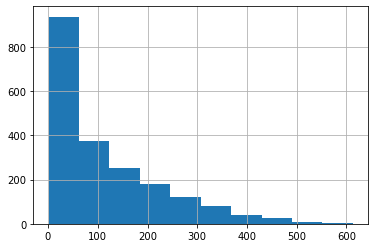

In [100]:
days_since_first_purch.hist()

In [101]:
# учитывая распределение, целесообразно взять медиану в качестве среднего количества дней между 1й и 2й покупкой - 
# используем этот вывод для опредения границ сегмента recency

days_since_first_purch.describe()

count    2029.000000
mean      113.666831
std       114.756983
min         1.000000
25%        22.000000
50%        73.000000
75%       175.000000
max       613.000000
Name: since_days, dtype: float64

In [102]:
# количество возвратов (повторных покупок) по истечению года ничтожно мало -
# используем этот вывод для опредления периода rfm-анализа

round((days_since_first_purch > 365).sum() / days_since_first_purch.sum() * 100, 2)

0.04

In [103]:
pd.concat([rfm.recency.describe(), days_since_first_purch.describe()], axis=1)

,recency,since_days
count,72543.000000,2029.000000
mean,172.965565,113.666831
std,99.948043,114.756983
min,1.000000,1.000000
25%,88.000000,22.000000
50%,172.000000,73.000000
75%,260.000000,175.000000
max,365.000000,613.000000


Сравнивая характеристики распределений выше прихожу к выводу, что для определения границ сегментов Recency вполне подходит квартильный метод. В 1ю (лучшую) группу у нас попадают пользователи, совершившие покупку в течении последних 88 дней - это почти медиана по средним возврата пользователей(73). Т.е. смысл работы с 1м сегментом дополняется еще и более высокой вероятностью ретеншена (не будем забывать, что пользователей, совершивших только одну покупку у нас абсолютное большинство). Последующие сегменты следуют той же логике: значимость группы уменьшается с уменьшением вероятности ретеншена.

1й сегмент до 88 дней

2й сегмент от 88 до 172 дней

3й сегмент от 172 до 260 дней

4й сегмент свыше 260 дней

In [104]:
#посмотрим, как частота влияет на выручку

In [105]:
rfm.frequency.value_counts()

1     70738
2      1684
3        94
4        17
5         5
7         3
11        1
9         1
Name: frequency, dtype: int64

In [106]:
# доля всех пользователей с разной частотой покупок в общей выручке

frac = uniq_cust_with_orders.groupby('customer_unique_id', as_index=False) \
                        .agg({'order_id': 'count', 'purch_sum': 'sum'}) \
                        .order_id.value_counts(normalize=True).mul(100).round(3)
frac

1     97.512
2      2.321
3      0.130
4      0.023
5      0.007
7      0.004
9      0.001
11     0.001
Name: order_id, dtype: float64

In [107]:
df = pd.concat([rfm.frequency.value_counts(), frac], axis=1)
df.columns=('customers_num', 'frac_revenue')
df

,customers_num,frac_revenue
1,70738,97.512
2,1684,2.321
3,94,0.130
4,17,0.023
5,5,0.007
7,3,0.004
11,1,0.001
9,1,0.001


Видно, что частота покупок очень слабо влияет на объем выручки, так как в нашем датасете количество пользоваетелй с последующими покупками экспоненциально убывает. Тем не менее важно сохранять лояльных клиентов и работать над повышением их количества. Исходя из особенностей датасета и проведенного ресёрча я бы определил следующие границы:

1й сегмент > 4 покупок

2й сегмент 3-4 покупки

3й сегмент 2 покупки

4й сегмент 1 покупка

In [108]:
# monetary

In [109]:
rfm.monetary.describe()

count    72543.000000
mean       141.095977
std        211.871185
min          0.850000
25%         47.900000
50%         89.800000
75%        152.000000
max      13440.000000
Name: monetary, dtype: float64

C:\Users\makog\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='monetary'>

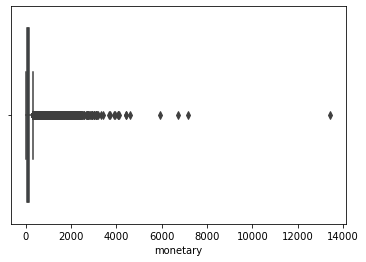

In [110]:
sns.boxplot(rfm.monetary)

In [111]:
# посмотрим на выброс внимательнее

monetary.monetary.idxmax()

'0a0a92112bd4c708ca5fde585afaa872'

In [112]:
customers.query('customer_unique_id == "0a0a92112bd4c708ca5fde585afaa872"')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
6195,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ


In [113]:
purchases.query('customer_id == "1617b1357756262bfa56ab541c47bc16"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
13390,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23


In [114]:
items.query('order_id == "03caa2c082116e1d31e67e9ae3700499"')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1647,03caa2c082116e1d31e67e9ae3700499,1,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1648,03caa2c082116e1d31e67e9ae3700499,2,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1649,03caa2c082116e1d31e67e9ae3700499,3,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1650,03caa2c082116e1d31e67e9ae3700499,4,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1651,03caa2c082116e1d31e67e9ae3700499,5,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1652,03caa2c082116e1d31e67e9ae3700499,6,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1653,03caa2c082116e1d31e67e9ae3700499,7,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01
1654,03caa2c082116e1d31e67e9ae3700499,8,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01


In [115]:
items.price.max()

6735.0

In [116]:
# пользователь единовременно купил 8 штук чего-то дорогого (но не самого), что вполне возможно..

In [117]:
# разобьем пользователей по сумме покупок, составляющей четверть от общей выручки

In [118]:
m = rfm.query('monetary >= 500').shape[0] / rfm.shape[0] *100
n = rfm.query('monetary >= 500').monetary.sum() / rfm.monetary.sum() * 100
print(f'{round(m)}% пользователей, потративших от 500 у.е., принесли {round(n)}% выручки')

4% пользователей, потративших от 500 у.е., принесли 25% выручки


In [119]:
m = rfm.query('200 <= monetary < 500').shape[0] / rfm.shape[0] *100
n = rfm.query('200 <= monetary < 500').monetary.sum() / rfm.monetary.sum() * 100
print(f'{round(m)}% пользователей, потративших от 200 до 500 у.е., принесли {round(n)}% выручки')

12% пользователей, потративших от 200 до 500 у.е., принесли 25% выручки


In [120]:
m = rfm.query('100 <= monetary < 200').shape[0] / rfm.shape[0] *100
n = rfm.query('100 <= monetary < 200').monetary.sum() / rfm.monetary.sum() * 100
print(f'{round(m)}% пользователей, потративших от 100 до 200 у.е., принесли {round(n)}% выручки')

27% пользователей, потративших от 100 до 200 у.е., принесли 28% выручки


In [121]:
m = rfm.query('monetary < 100').shape[0] / rfm.shape[0] *100
n = rfm.query('monetary < 100').monetary.sum() / rfm.monetary.sum() * 100
print(f'{round(m)}% пользователей, потративших менее 100 у.е., принесли {round(n)}% выручки')

57% пользователей, потративших менее 100 у.е., принесли 22% выручки


In [122]:
# описательные статистики распределений чеков по отдельным заказам и чеков, сгруппированных по уникальным пользователям
# практически одинаковы, т.к. преобладают одиночные заказы, 
# поэтому ресёчить в сторону повторых и последующих покупок нецелесообразно

pd.concat([uniq_cust_with_orders.purch_sum.describe(), rfm.monetary.describe()], axis=1)

,purch_sum,monetary
count,74522.000000,72543.000000
mean,137.349044,141.095977
std,206.819682,211.871185
min,0.850000,0.850000
25%,46.200000,47.900000
50%,87.505000,89.800000
75%,149.900000,152.000000
max,13440.000000,13440.000000


В данном случае считаю уместным сегментировать пользователей по их чекам на основании равных вкладов в выручку. Возрастающее количество пользователей по сегментам также может быть полезным для маркетинговых активностей. Например, вип-клентам из 1го сегмента можем предложить персонального менеджера, понимая, что ресурсов понадобиться относительно немного (4%), а влиять будем на четверть прибыли. Оптимум Парето на минималках:)

1й сегмент - от 500 у.е.

1й сегмент - 200 - 500 у.е.

1й сегмент - 100 - 200 у.е

1й сегмент - до 100 у.е.

In [123]:
rfm

,customer_unique_id,recency,frequency,monetary
0,55cfdb1ec3c5bf60d9ccc0d5f276f8a9,1,1,250.00
1,1041688b50cfd8ef6df6086a1746a30c,1,2,41.80
2,ca36d819c1759cdb6257fef0bb5d362d,1,1,7.50
3,afbcfd0b9c5233e7ccc73428526fbb52,1,1,457.75
4,0c6d7218d5f3fa14514fd29865269993,1,1,169.80
...,...,...,...,...
72538,140a739017666e061d00177428afcd55,365,1,109.90
72539,89bfe07c825cb356d8adb48036689efc,365,1,86.70
72540,caa82063c22259dc33023f5368f77220,365,1,77.80
72541,8215ca540d5abcc9e3564f69e898769f,365,1,29.99


In [124]:
def r_score(x):
    if x <= 88:
        return 1
    elif x <= 172:
        return 2
    elif x <= 260:
        return 3
    else:
        return 4

def f_score(x):
    if x > 4:
        return 1
    elif x > 2:
        return 2
    elif x == 2:
        return 3
    else:
        return 4
    
def m_score(x):
    if x >= 500:
        return 1
    elif x >= 200:
        return 2
    elif x >= 100:
        return 3
    else:
        return 4

In [125]:
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))

In [126]:
rfm

,customer_unique_id,recency,frequency,monetary,R,F,M
0,55cfdb1ec3c5bf60d9ccc0d5f276f8a9,1,1,250.00,1,4,2
1,1041688b50cfd8ef6df6086a1746a30c,1,2,41.80,1,3,4
2,ca36d819c1759cdb6257fef0bb5d362d,1,1,7.50,1,4,4
3,afbcfd0b9c5233e7ccc73428526fbb52,1,1,457.75,1,4,2
4,0c6d7218d5f3fa14514fd29865269993,1,1,169.80,1,4,3
...,...,...,...,...,...,...,...
72538,140a739017666e061d00177428afcd55,365,1,109.90,4,4,3
72539,89bfe07c825cb356d8adb48036689efc,365,1,86.70,4,4,4
72540,caa82063c22259dc33023f5368f77220,365,1,77.80,4,4,4
72541,8215ca540d5abcc9e3564f69e898769f,365,1,29.99,4,4,4


In [127]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

In [128]:
rfm.tail()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score
72538,140a739017666e061d00177428afcd55,365,1,109.90,4,4,3,443
72539,89bfe07c825cb356d8adb48036689efc,365,1,86.70,4,4,4,444
72540,caa82063c22259dc33023f5368f77220,365,1,77.80,4,4,4,444
72541,8215ca540d5abcc9e3564f69e898769f,365,1,29.99,4,4,4,444
72542,cadf5efd7e29678690c09cc039e08bc6,365,1,117.99,4,4,3,443
